In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# hi_maps= np.load("/home/urwa/MASS_Thesis/HI/hi_corr_maps.npy")
# noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")*1e3
# ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
# sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")
# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

# fgds=ff+sync/1e8
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
# cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
# cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
# *_,noise_binned= bin_spectra(cl_noise, 10)
# *_, fgds_binned= bin_spectra(cl_fgds, 10)
# total=hi_maps + noise_maps[:54] +fgds
# cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
# *_, chat_binned= bin_spectra(cl_hat, 10)

In [7]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

log polynomial fitting  $\sum_k^d a_k(log (l))^k$ for a fixed frequency 

In [324]:
f=50

In [325]:
log_ell = np.log10(leff)
log_hi= np.log10(hi_d[:,f,f])
coeffs_k= np.polyfit(log_ell, log_hi, 7)
log_hi_fit = np.polyval(coeffs_k, log_ell)
hi_fit = (10**(log_hi_fit))  # bring back to linear scale

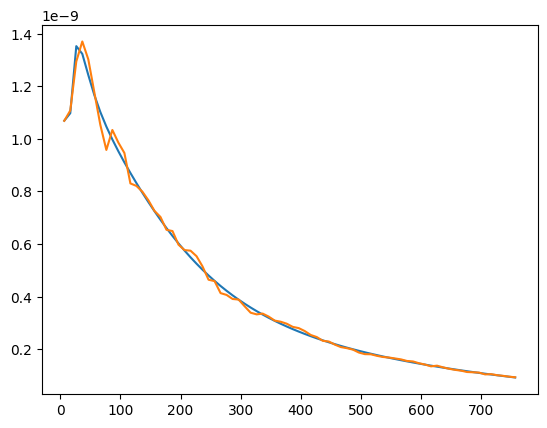

In [326]:
plt.plot(leff,hi_fit, label='Fitted HI')
plt.plot(leff, hi_d[:,f,f], label='Binned HI')

log polynomial fitting  $\sum_m^d a_m(log (\nu))^m$ for a fixed ell

In [327]:
l=70

In [328]:
# Extract diagonal
i = np.arange(nfreqs)
y = np.diag(hi_d[l])

# Avoid log(0) by shifting index
log_i = np.log10(i+1 )   
log_y = np.log10(y)       # assuming y > 0

# Fit polynomial in log(i)
degree = 3
coeffs_m = np.polyfit(log_i, log_y, degree)

In [329]:
coeffs_m

array([-1.69012581e-01,  6.85382652e-03, -1.74922665e-01, -8.84739231e+00])

In [330]:
# Evaluate log-polynomial
log_y_fit = np.polyval(coeffs_m, log_i)
y_fit = (10**(log_y_fit))  # bring back to linear scale

# Replace diagonal in the matrix
M_fit = hi_d[l].copy()
print(M_fit.shape)
print(y_fit.shape)
np.fill_diagonal(M_fit, y_fit)

(54, 54)
(54,)


Building the covariance in frequency

In [331]:
B = np.outer(np.sqrt(y_fit), np.sqrt(y_fit))
H= np.outer(np.sqrt(y), np.sqrt(y))

Checing the fit

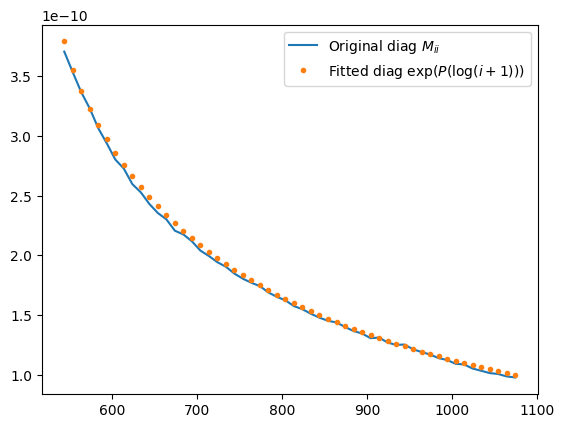

In [332]:

plt.plot(freqs[:-1], H[f+2], label='Original diag $M_{ii}$')
plt.plot(freqs[:-1], B[f+2],'.', label='Fitted diag $\exp(P(\log(i+1)))$')
plt.legend()
plt.show()

Building the total covariance by taking the tensor product

In [383]:
C_model = np.zeros((nbins, nfreqs, nfreqs))
n=0
for b in range(nbins):
    C_model[b] = ((freqs[:-1]/freqs[0])**n_nu[b])*hi_fit[b] * np.identity(54)*B#@np.identity(54)*B.T  # scalar * matrix



In [384]:
l=70

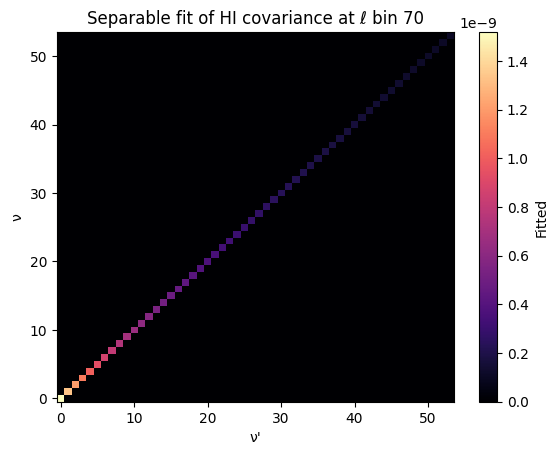

In [387]:
plt.imshow(C_model[l]/1e-10, origin='lower', cmap='magma', aspect='auto') #, vmin=0, vmax=1.5e-9
plt.colorbar(label='Fitted')
plt.title(f"Separable fit of HI covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()

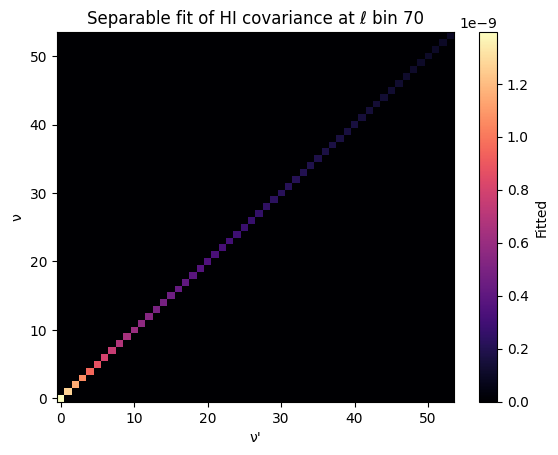

In [388]:
plt.imshow(hi_d[l], origin='lower', cmap='magma', aspect='auto') #, vmin=0, vmax=1.5e-9
plt.colorbar(label='Fitted')
plt.title(f"Separable fit of HI covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()

Fit n as a polynimial in ell too

In [378]:
# allocate
n_fit = np.zeros(nbins)

for i in range(nbins):
    # 1a) empirical diagonal at this ell
    Cdiag = np.diag(hi_d[i,:,:])
    B_nu = np.sum(B, axis=0)
    # 1b) divide out A and B^2 so that residual ~ (nu/nu0)^(-n_i)
    Rres   = Cdiag / (hi_fit[i] * B_nu**2)             # (nf,)
    
    # 1c) do a linear fit in log–log: log Rres = slope * log(nu/nu0) + const
    x = np.log(freqs[:-1]/freqs[0])
    y = np.log(Rres)
      # sanity check
    # print(B.shape)
    slope, intercept = np.polyfit(x, y, 1)

    # because Rres ≈ (nu/nu0)^(-n_i) → log Rres = -n_i * log(nu/nu0)
    n_fit[i] = -slope

In [379]:
# choose degree of the n(ell) polynomial
e = 3   # e.g. quadratic in log ell

# regress n_fit[i] = sum_{q=0}^e c_q [log ell_i]^q
c_coeffs = np.polyfit(log_ell, n_fit, e)
# c_coeffs[0] is highest power if you use np.polyfit,
# or reorder as you like for np.polyval later.

# if you want them in increasing order (c_0 + c_1 x + ...), do:
c_coeffs = c_coeffs[::-1]

In [380]:
c_coeffs

array([-3.56413057, 13.40839376, -8.76414058,  1.57813129])

In [381]:
n_nu  = sum(c_coeffs[q] * log_ell**q   for q in range(e+1))  # (nf,)

In [382]:
n_nu

array([ 2.39190705,  2.6175291 ,  2.31611659,  2.01025162,  1.74243321,
        1.51250528,  1.31474619,  1.1435437 ,  0.99426967,  0.86324797,
        0.74757066,  0.64492266,  0.55344245,  0.47161703,  0.39820361,
        0.33217108,  0.27265597,  0.21892901,  0.17036943,  0.12644498,
        0.0866963 ,  0.05072452,  0.01818135, -0.0112389 , -0.03780584,
       -0.06175829, -0.08330868, -0.1026467 , -0.11994233, -0.13534842,
       -0.14900282, -0.16103026, -0.17154387, -0.18064656, -0.18843216,
       -0.19498643, -0.20038792, -0.20470874, -0.20801519, -0.2103684 ,
       -0.21182475, -0.21243643, -0.21225175, -0.21131552, -0.2096694 ,
       -0.20735213, -0.20439981, -0.20084611, -0.1967225 , -0.19205839,
       -0.18688132, -0.18121712, -0.17509001, -0.16852275, -0.16153673,
       -0.15415209, -0.1463878 , -0.13826175, -0.12979082, -0.12099094,
       -0.11187718, -0.1024638 , -0.09276429, -0.08279143, -0.07255734,
       -0.06207351, -0.05135086, -0.04039976, -0.02923005, -0.01